In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import dateutil.parser

from matplotlib.dates import DateFormatter
from datetime import timedelta

itunes_top = pd.read_csv("itunes_top.csv")
itunes_top["day"] = pd.to_datetime(itunes_top["day"],
                                    infer_datetime_format=True)

In [2]:
plt.rcParams.update({'font.size': 15})

In [3]:
itunes_top["year"] = itunes_top["day"].dt.year
itunes_top.head()

,day,title,position,last_week_position,weeks_on_chart,year
0,2014-04-26,#ABLACKSHOW w/ @elonjames White,53,NaN,1,2014
1,2015-08-26,#DateFails,67,NaN,1,2015
2,2015-08-27,#DateFails,74,67.0,2,2015
3,2015-08-28,#DateFails,78,74.0,3,2015
4,2015-08-29,#DateFails,67,78.0,4,2015


## Average lifetime

In [13]:
itunes_top["max_weeks_on_chart"] = itunes_top.groupby(["title"])["weeks_on_chart"].transform("max")

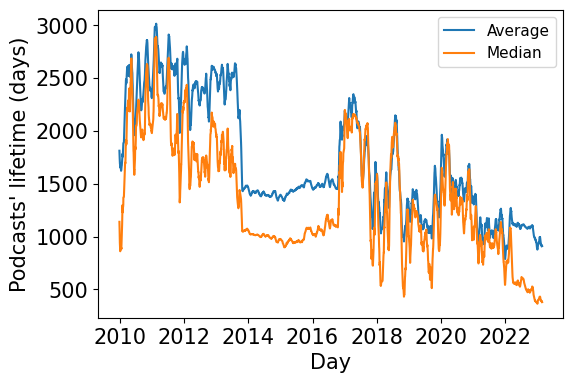

In [26]:
avg_weeks_on_chart = itunes_top[["day", "max_weeks_on_chart"]].groupby(
    by="day").mean().rolling(window=30).mean()

median_weeks_on_chart = itunes_top[["day", "max_weeks_on_chart"]].groupby(
    by="day").median().rolling(window=30).mean()

plt.figure(figsize=(6, 4))
plt.plot(avg_weeks_on_chart, label="Average")
plt.plot(median_weeks_on_chart, label="Median")

plt.xlabel("Day")
plt.ylabel("Podcasts' lifetime (days)")
plt.legend(["Average", "Median"], fontsize=11)

plt.savefig("figures/average_days_on_chart.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Proportion of new podcasts

In [5]:
itunes_top["new_song"] = itunes_top["last_week_position"].map(
    lambda position: True if np.isnan(position) else False)

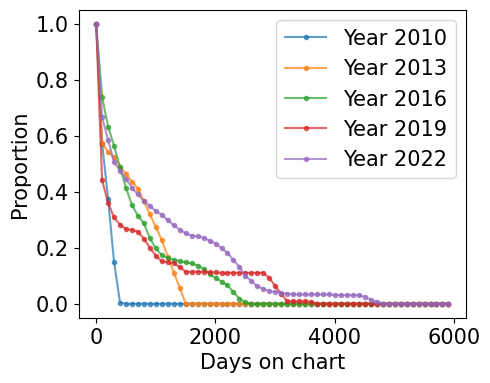

In [6]:
plt.figure(figsize=(5, 4))

for year in range(2010, 2023, 3):
    proportion_of_podcasts_older_than_x_weeks = []
    for i in range(1, 6000, 100):
        proportion_of_podcasts_older_than_x_weeks.append(
            itunes_top[(itunes_top["weeks_on_chart"] >= i) & (itunes_top["year"] == year)].shape[0] / itunes_top[itunes_top["year"] == year].shape[0])
    plt.plot(range(1, 6000, 100), proportion_of_podcasts_older_than_x_weeks, marker='o', ms=3,
             alpha=0.7)

plt.xlabel("Days on chart")
plt.ylabel("Proportion")
plt.legend([f"Year {year}" for year in range(2010, 2023, 3)])
plt.savefig("figures/proportion_of_podcasts_older_than_x_days.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Position change

In [7]:
grouped = itunes_top.groupby(["title"])
rows_to_add = []

for name, group in grouped:
    max_week = group["day"].max()

    for row_index, row in group.iterrows():
        if row["day"] == max_week:
            rows_to_add.append({
                "title": row["title"],
                "day": row["day"] + timedelta(weeks=1),
                "position": 101,
                "last_week_position": row["position"],
                "weeks_on_chart": row["weeks_on_chart"]
            })

itunes_top_with_disappeared_songs = pd.concat([itunes_top, pd.DataFrame.from_records(rows_to_add)], ignore_index=True)

C:\Users\cutie\AppData\Local\Temp\ipykernel_7576\2315331605.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:


In [8]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return 100 - position
    return last_week_position - position

itunes_top_with_disappeared_songs["position_change"] = itunes_top_with_disappeared_songs.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

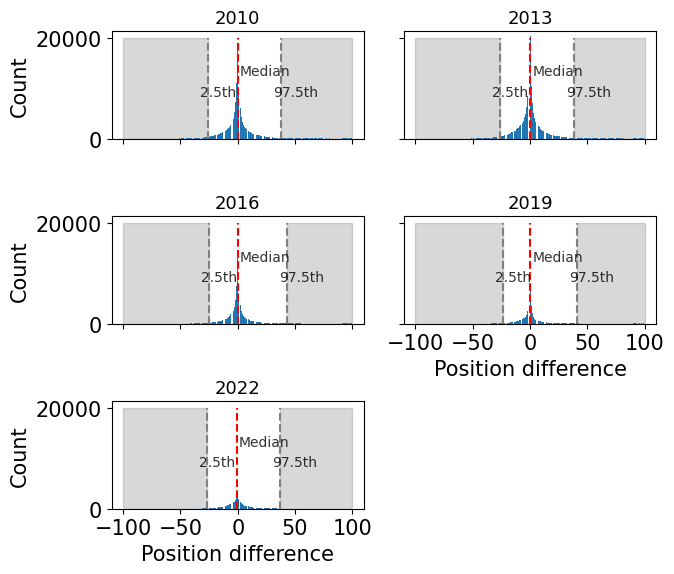

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(7, 6), sharex=True, sharey=True)

row = 0
col = 0

billboard_subset = itunes_top_with_disappeared_songs[["year", "day", "position_change"]]

for year in range(2010, 2023, 3):
    decade_subset = billboard_subset[(billboard_subset["year"] >= year) &\
        (billboard_subset["year"] < year + 10)]["position_change"]
    count_changes = decade_subset.value_counts().sort_index()

    perecentile_25 = decade_subset.quantile(0.025)
    perecentile_975 = decade_subset.quantile(0.975)
    perecentile_50 = decade_subset.quantile(0.5)

    axes[row, col].vlines(perecentile_25, ymin=0, ymax=20000, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_975, ymin=0, ymax=20000, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_50, ymin=0, ymax=20000, color="red", linestyle='--')
    
    # mark the percentiles 
    rect_left = patches.Rectangle((-100, 0), 100 + perecentile_25, 20000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_left)
    axes[row, col].text(perecentile_25 - 7, 8500, "2.5th", size = 10, alpha = 0.8)
    rect_right = patches.Rectangle((perecentile_975, 0), 100 - perecentile_975, 20000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_right)
    axes[row, col].text(perecentile_975 - 7, 8500, "97.5th", size = 10, alpha = 0.8)

    axes[row, col].text(perecentile_50 + 2, 12500, "Median", size = 10, alpha = 0.8)

    axes[row, col].bar(count_changes.index, count_changes.values)
    axes[row, col].set_title(f"{year}", fontsize=13)
    if row == 2 or ((row == 1) and (col == 1)):
        axes[row, col].set_xlabel("Position difference")
        axes[row, col].xaxis.set_tick_params(labelbottom=True)
        axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(5))
    if col == 0:
        axes[row, col].set_ylabel("Count")
    col += 1
    if col == 2:
        col = 0
        row += 1

fig.delaxes(axes[2, 1])
fig.tight_layout()
plt.savefig("figures/position_difference_distribution.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Normalized trajectories

In [10]:
def get_top_positions_range(position):
    if position <= 10:
        return "1-10"
    elif position <= 20:
        return "11-20"
    elif position <= 30:
        return "21-30"
    elif position <= 40:
        return "31-40"
    elif position <= 50:
        return "41-50"
    elif position <= 60:
        return "51-60"
    elif position <= 70:
        return "61-70"
    elif position <= 80:
        return "71-80"
    elif position <= 90:
        return "81-90"
    else:
        return "91-100"

itunes_top["top_position"] = itunes_top.groupby(
    ["title"])["position"].transform("min")

itunes_top["top_positions_range"] = itunes_top["top_position"].map(
    lambda position: get_top_positions_range(position))

In [19]:
rows_to_add = []

grouped = itunes_top.groupby(["title"])

min_first_week = itunes_top["day"].min().to_pydatetime()

for name, group in grouped:
    max_week = group["day"].max().to_pydatetime()

    for row_index, row in group.iterrows():
        if row["day"] == max_week:
            week_date = row["day"] + timedelta(weeks=1)

            while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                if week_date < dateutil.parser.parse(f"2013-09-25"):
                    rows_to_add.append({
                        "title": row["title"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 11,
                        "day": week_date,
                        "year": week_date.year,
                        "top_position": row["top_position"]
                    })
                else:
                    rows_to_add.append({
                        "title": row["title"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "day": week_date,
                        "year": week_date.year,
                        "top_position": row["top_position"]
                    })
                week_date += timedelta(weeks=1)

itunes_top_with_empty_weeks = pd.concat([itunes_top[["title", "weeks_on_chart",
    "position", "day", "year", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

itunes_top_with_empty_weeks["first_week"] = itunes_top_with_empty_weeks.groupby(["title"])["day"].transform("min")

C:\Users\cutie\AppData\Local\Temp\ipykernel_7576\729242464.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:


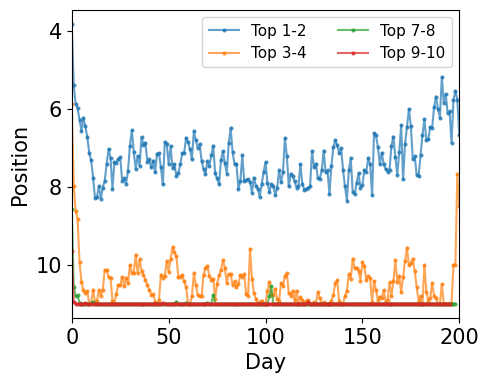

In [23]:
plt.figure(figsize=(5, 4))

itunes_top_subset = itunes_top[itunes_top["day"] < dateutil.parser.parse(f"2013-09-25")]
itunes_top_subset_empty_weeks = itunes_top_with_empty_weeks[itunes_top_with_empty_weeks["day"] < dateutil.parser.parse(f"2013-09-25")]

for top_position, low_positions in [(1, 2),  (3, 4), (7, 8), (9, 10)]:
    top_x_positions = itunes_top_subset[(itunes_top_subset["top_position"] <= low_positions) &\
        (itunes_top_subset["top_position"] >= top_position)][["title"]]

    # take all positions of the podcasts
    top_x_positions = top_x_positions[["title"]].drop_duplicates().merge(
        itunes_top_subset_empty_weeks[["title", "position", "day",
            "first_week"]], on=["title"], how="left")

    min_first_week = top_x_positions["day"].min().to_pydatetime()

    top_x_positions["day"] = top_x_positions.apply(lambda row:
            int(((min_first_week + timedelta(
                    days=(row["day"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    top_x_positions.set_index("day", inplace=True)
    top_x_positions.sort_index(inplace=True)

    plt.plot(top_x_positions.groupby("day")["position"].mean(),
        marker='o', label=f"Top {top_position}-{low_positions}", ms=2, alpha=0.7)

plt.xlabel("Day")
plt.ylabel("Position")
plt.xlim([0, 200])
plt.legend(bbox_to_anchor=(1, 1), fontsize=11, ncol=2)

plt.gca().invert_yaxis()
plt.savefig("figures/average_position_change_per_top_position_10.pdf", format="pdf", bbox_inches="tight")
plt.show()

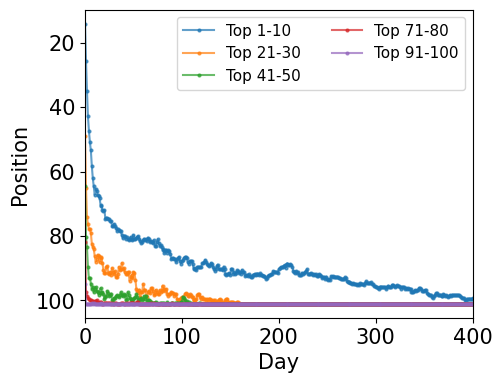

In [21]:
plt.figure(figsize=(5, 4))

itunes_top_subset = itunes_top[itunes_top["day"] >= dateutil.parser.parse(f"2013-09-25")]
itunes_top_subset_empty_weeks = itunes_top_with_empty_weeks[itunes_top_with_empty_weeks["day"] >= dateutil.parser.parse(f"2013-09-25")]

for top_position, low_positions in [(1, 10),  (21, 30), (41, 50), (71, 80), (91, 100)]:
    top_x_positions = itunes_top_subset[(itunes_top_subset["top_position"] <= low_positions) &\
        (itunes_top_subset["top_position"] >= top_position)][["title"]]

    # take all positions of the podcasts
    top_x_positions = top_x_positions[["title"]].drop_duplicates().merge(
        itunes_top_subset_empty_weeks[["title", "position", "day",
            "first_week"]], on=["title"], how="left")

    min_first_week = top_x_positions["day"].min().to_pydatetime()

    top_x_positions["day"] = top_x_positions.apply(lambda row:
            int(((min_first_week + timedelta(
                    days=(row["day"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    top_x_positions.set_index("day", inplace=True)
    top_x_positions.sort_index(inplace=True)

    plt.plot(top_x_positions.groupby("day")["position"].mean(),
        marker='o', label=f"Top {top_position}-{low_positions}", ms=2, alpha=0.7)

plt.xlabel("Day")
plt.ylabel("Position")
plt.xlim([0, 400])
plt.legend(bbox_to_anchor=(1, 1), fontsize=11, ncol=2)

plt.gca().invert_yaxis()
plt.savefig("figures/average_position_change_per_top_position.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Average max/past/future days on chart

In [37]:
def get_past_weeks(row):
    top_position = row["top_position"].iloc[0]
    # take first day of the week when the podcast was in top position
    top_position_time = row[
        (row["position"] == top_position)]["day"].values[0]
    past_weeks = row[
        (row["day"] <= top_position_time)]["weeks_on_chart"].max()
    return past_weeks

In [38]:
def get_future_weeks(row):
    top_position = row["top_position"].iloc[0]
    past_weeks = row["past_weeks"].iloc[0]
    # take first day of the week when the podcast was in top position
    top_position_time = row[
        (row["position"] == top_position)]["day"].values[0]
    max_weeks = row[
        (row["day"] > top_position_time)]["weeks_on_chart"].max()
    if max_weeks is np.nan or max_weeks == 0:
        return 0
    future_weeks = max_weeks - past_weeks
    if future_weeks is np.nan or future_weeks < 0:
        return 0
    return future_weeks

In [39]:
df_past_weeks = itunes_top.groupby(["title"]).apply(
    lambda row: get_past_weeks(row)).rename("past_weeks").reset_index()
itunes_top = itunes_top.merge(df_past_weeks[["title", "past_weeks"]], on=["title"], how="left")

df_future_weeks = itunes_top.groupby(["title"]).apply(
    lambda row: get_future_weeks(row)).rename("future_weeks").reset_index()
itunes_top = itunes_top.merge(df_future_weeks[["title", "future_weeks"]], on=["title"], how="left")

itunes_top["max_weeks_on_chart"] = itunes_top.groupby(["title"])["weeks_on_chart"].transform("max")

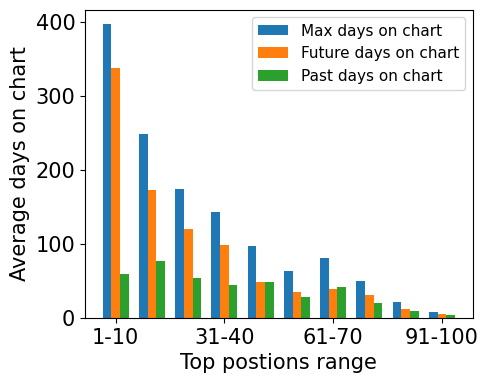

In [52]:
plt.figure(figsize=(5, 4))

top_positions_max = pd.DataFrame(columns=["top_positions_range", "avg_weeks"])
top_positions_future = pd.DataFrame(columns=["top_positions_range", "avg_weeks"])
top_positions_past = pd.DataFrame(columns=["top_positions_range", "avg_weeks"])
for top_position in range(10, 110, 10):
    avg_max_weeks = itunes_top[(itunes_top["top_position"] <= top_position) &\
        (itunes_top["top_position"] > top_position - 10)].groupby(
            ["title"])["max_weeks_on_chart"].first().mean()
    new_row_max = pd.DataFrame({"top_positions_range": f"{top_position - 9}-{top_position}",
        "avg_weeks": avg_max_weeks}, index=[0])
    top_positions_max = pd.concat([top_positions_max, new_row_max])

    avg_future_weeks = itunes_top[(itunes_top["top_position"] <= top_position) &\
        (itunes_top["top_position"] > top_position - 10)].groupby(
            ["title"])["future_weeks"].first().mean()
    new_row_future = pd.DataFrame({"top_positions_range": f"{top_position - 9}-{top_position}",
        "avg_weeks": avg_future_weeks}, index=[0])
    top_positions_future = pd.concat([top_positions_future, new_row_future])

    avg_past_weeks = itunes_top[(itunes_top["top_position"] <= top_position) &\
        (itunes_top["top_position"] > top_position - 10)].groupby(
            ["title"])["past_weeks"].first().mean()
    new_row_past = pd.DataFrame({"top_positions_range": f"{top_position - 9}-{top_position}",
        "avg_weeks": avg_past_weeks}, index=[0])
    top_positions_past = pd.concat([top_positions_past, new_row_past])

ind = np.arange(top_positions_max["top_positions_range"].shape[0])
bar_width = 0.24
plt.bar(ind, top_positions_max["avg_weeks"], bar_width, label="Max days on chart")
plt.bar(ind + bar_width, top_positions_future["avg_weeks"], bar_width, label="Future days on chart")
plt.bar(ind + 2*bar_width, top_positions_past["avg_weeks"], bar_width, label="Past days on chart")
plt.xlabel("Top postions range")
plt.ylabel("Average days on chart")
plt.xticks(ind + bar_width, top_positions_max["top_positions_range"].tolist())
plt.legend(fontsize=11)
plt.locator_params(axis='x', nbins=4)

plt.savefig("figures/average_days_on_chart_per_top_position.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Max days distribution

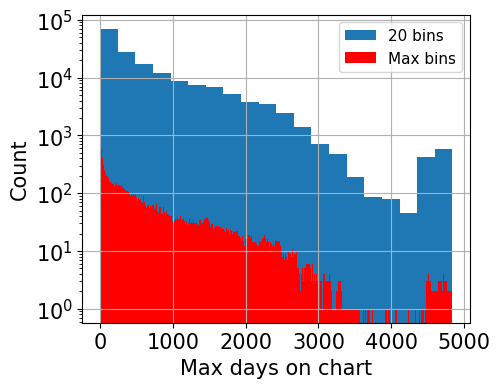

In [55]:
plt.figure(figsize=(5, 4))

weeks_on_chart_counts = itunes_top["weeks_on_chart"]

weeks_on_chart_counts.hist(bins=20, figsize=(5, 4), legend=False)
weeks_on_chart_counts.hist(bins=itunes_top["weeks_on_chart"].max(), figsize=(5, 4), legend=False, color="red")

max_weeks = itunes_top["weeks_on_chart"].max()
plt.xlabel("Max days on chart")
plt.ylabel("Count")
plt.legend([f"20 bins", f"Max bins"], fontsize=11)
plt.yscale("log")

plt.savefig("figures/max_days_on_chart_distribution.pdf", format="pdf", bbox_inches="tight")
plt.show()